In [1]:
# General
import numpy as np
import pandas as pd
import os
import jumpmodels.utils

# For loading data and feature engineering
from feature_25 import DataLoader

# For data prep and pre-processing
from jumpmodels.utils import filter_date_range 
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd 

# For model fit and prediction
from joblib import Parallel, delayed # allows parallel grid search on all 4 cores
from jumpmodels.sparse_jump import SparseJumpModel

# For plotting
from jumpmodels.plot import plot_regimes_and_cumret, plot_cumret

In [3]:
import importlib
import feature_25  # or whatever your module name is
importlib.reload(feature_25)


<module 'feature_25' from 'c:\\Users\\victo\\0_thesis_repo\\thesis_vri_vp\\victor\\feature_25.py'>

In [ ]:
# Import data
# -------------------------

# Define file path
directory = r"C:\Users\victo\0_thesis_repo\thesis_vri_vp\data"
file_path = os.path.join(directory, "factor_data.csv")

## Load the full returns dataset
#factor_data = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
#factor_data = factor_data.dropna() # Remove NaN rows (since markets were closed)
## Select a target return series for financial anchoring (e.g., first factor)
#ret_ser = factor_data.iloc[:, 0]  # First column as reference return series

# Use DataLoader to generate features
data = DataLoader(file_path=file_path, ver="v1", factor_col="IWF").load(start_date="2002-05-31", end_date="2025-02-24")
data.X = data.X.dropna()
data.ret_ser = data.ret_ser.dropna()

print("Daily returns:", data.ret_ser)
print("Engineered features:", data.X)

# Compute cumulative returns
#cumulative_returns = (1 + factor_data).cumprod()

# Plot cumulative returns
#plot_cumret(factor_data)
#plt.show()


Daily returns: Date
2002-05-31   -0.005607
2002-06-03   -0.030221
2002-06-04    0.007441
2002-06-05    0.012235
2002-06-06   -0.023033
                ...   
2025-02-18   -0.000096
2025-02-19    0.000360
2025-02-20   -0.005282
2025-02-21   -0.022690
2025-02-24   -0.010225
Name: IWF, Length: 5721, dtype: float64
Engineered features:             ActiveReturn_EWMA_8  ActiveReturn_EWMA_21  ActiveReturn_EWMA_63      RSI_8     RSI_21     RSI_63  StochOsc_%K_8  StochOsc_%K_21  StochOsc_%K_63  MACD_8_21  MACD_21_63  DownsideDev_log_21  ActiveMarketBeta_EWMA_21
Date                                                                                                                                                                                                                            
2002-08-28            -0.000067              0.000124              0.000113  43.333479  50.725539  43.456723       0.000000       61.577456       44.343291   0.020549   -0.854849          -11.336530                  

In [3]:
# Train/test split
# -------------------------

train_start, test_start = "2002-05-31", "2022-01-01"
# filter dates
X_train = filter_date_range(data.X, start_date=train_start, end_date=test_start)
X_test = filter_date_range(data.X, start_date=test_start)
# print time split
train_start, train_end = X_train.index[[0, -1]]
test_start, test_end = X_test.index[[0, -1]]
print("Training starts at:", train_start, "and ends at:", train_end)
print("Testing starts at:", test_start, "and ends at:", test_end)

# Preprocessing
# -------------------------

# Clip the data within 3 standard deviations to mitigate the impact of outliers and standardize the clipped data (zero mean and unit variance)
clipper = DataClipperStd(mul=3.)
scalar = StandardScalerPD()
# fit on training data
X_train_processed = scalar.fit_transform(clipper.fit_transform(X_train))
# transform the test data
X_test_processed = scalar.transform(clipper.transform(X_test))

Training starts at: 2002-05-31 00:00:00 and ends at: 2021-12-31 00:00:00
Testing starts at: 2022-01-03 00:00:00 and ends at: 2025-02-24 00:00:00


In [ ]:
""" # Check for NaN values
print("NaN values per column:")
print(X_train.isna().sum())

# Check for infinite values
print("\nInfinite values per column:")
print(np.isinf(X_train).sum())

# Find extremely large values (greater than 1e10)
large_values_mask = (np.abs(X_train) > 1e10)
print("\nNumber of extremely large values per column:")
print(large_values_mask.sum())

# Print specific rows with large values
if large_values_mask.any().any():
    print("\nRows containing large values:")
    print(X_train[large_values_mask.any(axis=1)]) """


NaN values per column:
ret_5         0
DD-log_5      0
sortino_5     0
ret_20        0
DD-log_20     0
sortino_20    0
ret_60        0
DD-log_60     0
sortino_60    0
dtype: int64

Infinite values per column:
ret_5         0
DD-log_5      0
sortino_5     0
ret_20        0
DD-log_20     0
sortino_20    0
ret_60        0
DD-log_60     0
sortino_60    0
dtype: int64

Number of extremely large values per column:
ret_5         0
DD-log_5      0
sortino_5     0
ret_20        0
DD-log_20     0
sortino_20    0
ret_60        0
DD-log_60     0
sortino_60    0
dtype: int64


In [4]:
# **Time-Series Cross-Validation for Jump Penalty (λ) and Max Features (κ²) Optimization**
def rolling_window_cv(lam, kappa, X, y, n_splits=5, min_train_size=5*252):
    """
    Perform rolling expanding window cross-validation.
    - min_train_size ensures at least 5 years of training data.
    - The test period expands as time progresses.
    """
    split_size = (len(X) - min_train_size) // n_splits
    scores = []
    max_feats = int(kappa ** 2)

    for i in range(n_splits):
        train_end = min_train_size + i * split_size
        X_train_cv, y_train_cv = X.iloc[:train_end], y.iloc[:train_end] # selects the first train_end rows from X and y, creating a training dataset.
        X_val_cv, y_val_cv = X.iloc[train_end:], y.iloc[train_end:] # selectes the rows after train_end and forward to be used for out of sample validation

        model = SparseJumpModel(n_components=2, max_feats=max_feats, jump_penalty=lam, cont=False, max_iter=10)
        model.fit(X_train_cv, y_train_cv, sort_by="cumret")
        predicted_states = model.predict(X_val_cv)

        # Compute performance metric (e.g., Sharpe Ratio)
        returns = (y_val_cv * (predicted_states == 0)).sum()  # Returns during "good" regimes
        risk = (y_val_cv * (predicted_states == 1)).std()  # Risk during "bad" regimes
        sharpe_ratio = returns / risk if risk != 0 else 0

        scores.append(sharpe_ratio)

    return np.mean(scores)

# **Parallelized Cross-Validation Across Multiple (λ, κ) Values**
lambda_values = np.logspace(0, 2, 10)  # λ values from 1 to 100
kappa_values = np.linspace(1, np.sqrt(X_train_processed.shape[1]), 10)  # κ values

results = Parallel(n_jobs=4)(
    delayed(rolling_window_cv)(lam, kappa, X_train_processed, data.ret_ser)
    for lam in lambda_values
    for kappa in kappa_values
)

# Select the best (λ, κ) combination
best_index = np.argmax(results)
best_lambda = lambda_values[best_index // len(kappa_values)]
best_kappa = kappa_values[best_index % len(kappa_values)]
max_feats_best = int(best_kappa ** 2)

print(f"Best Jump Penalty (λ): {best_lambda}")
print(f"Best Max Features (κ²): {max_feats_best}")

Best Jump Penalty (λ): 21.544346900318832
Best Max Features (κ²): 1


[Text(0.5, 1.0, 'Best SJM ($\\lambda$=21.544346900318832, $\\kappa^2$=1)')]

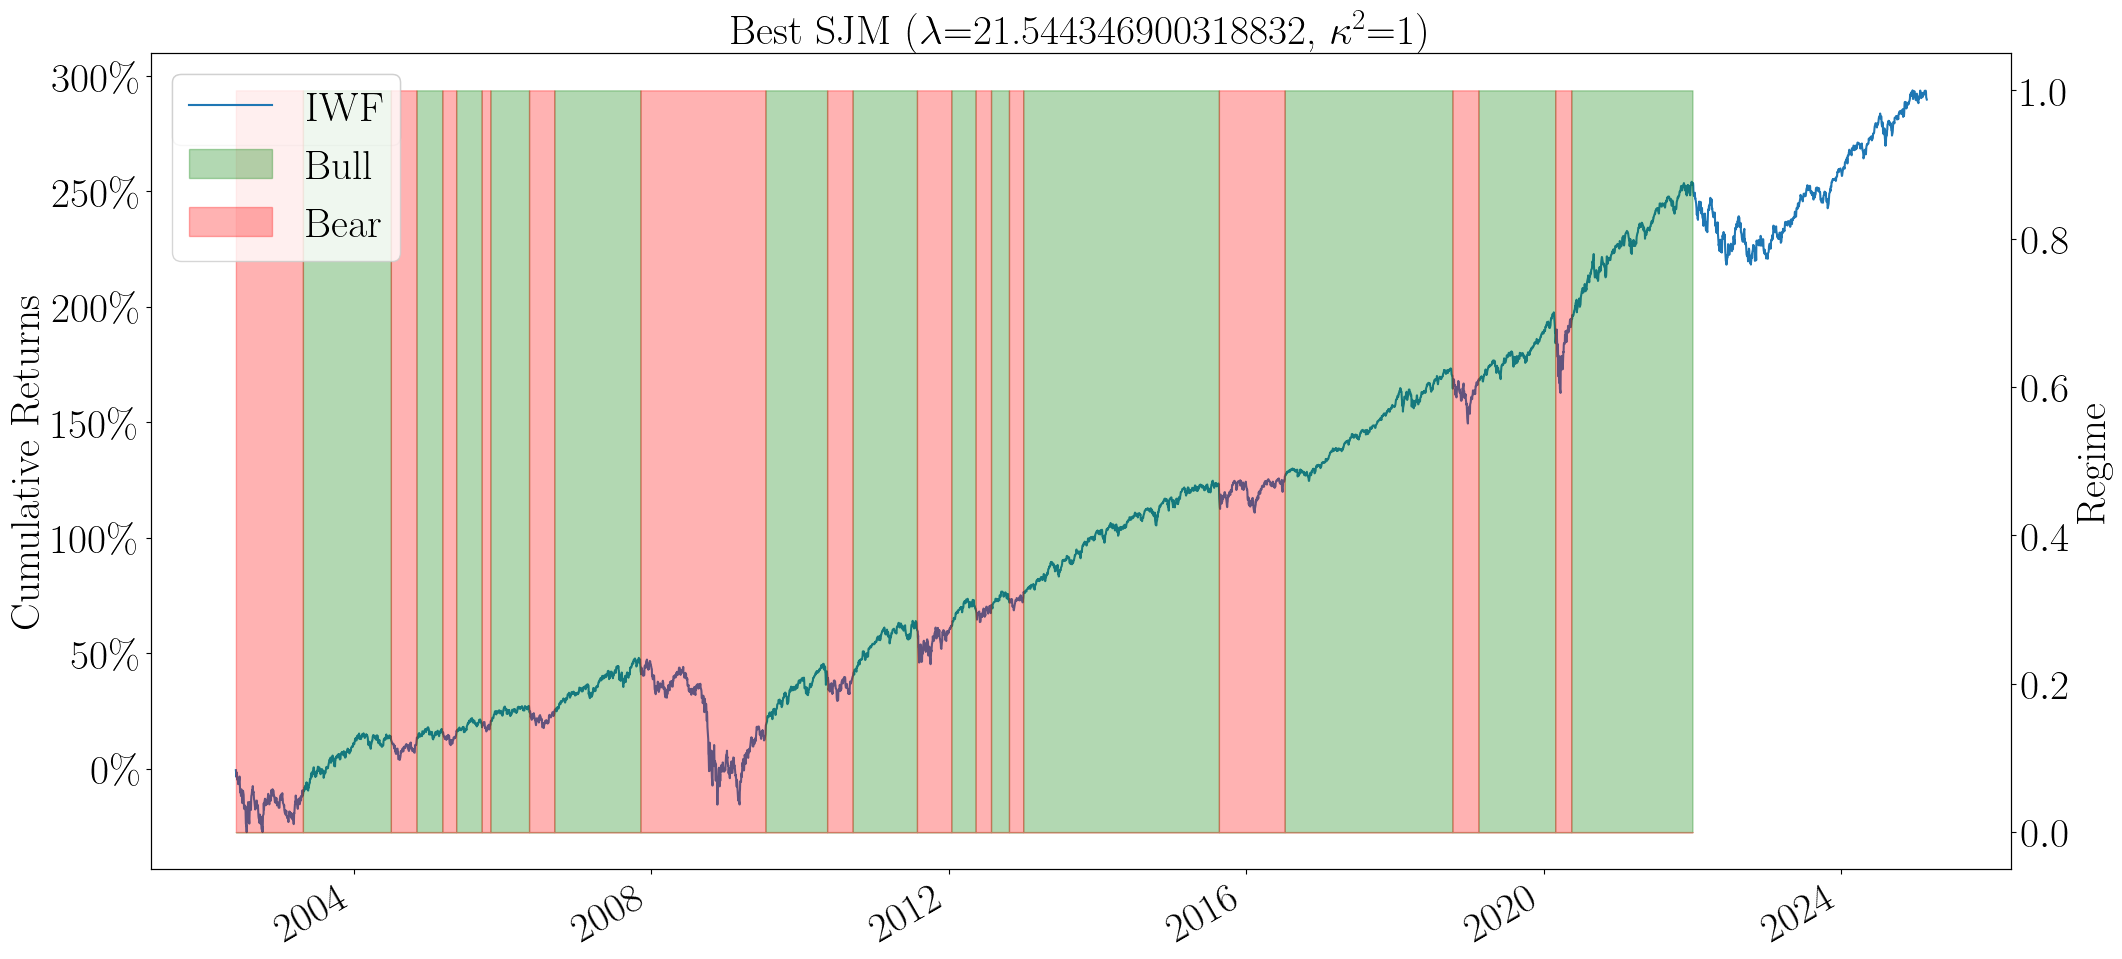

In [6]:
# -------------------------
# Fit the Sparse Jump Model
# -------------------------


# **Final Model Training with Best (λ, κ) Values**
best_model = SparseJumpModel(n_components=2, max_feats=max_feats_best, jump_penalty=best_lambda, cont=False, max_iter=10)
best_model.fit(X_train_processed, data.ret_ser, sort_by="cumret")

# **Predict and Plot Results**
predicted_states = best_model.predict(X_train_processed)
ax, ax2 = plot_regimes_and_cumret(predicted_states, data.ret_ser)
ax.set(title=f"Best SJM ($\\lambda$={best_lambda}, $\\kappa^2$={max_feats_best})")
#plt.show()


In [8]:
# Predict the states on the in-sample data
print("Predicted states (in-sample):")
print(predicted_states)

# Print the feature weights (sparse weights)
print("SJM Feature Weights:")
print(best_model.feat_weights)

Predicted states (in-sample):
Date
2002-05-31    1
2002-06-03    1
2002-06-04    1
2002-06-05    1
2002-06-06    1
             ..
2021-12-27    0
2021-12-28    0
2021-12-29    0
2021-12-30    0
2021-12-31    0
Length: 4933, dtype: int64
SJM Feature Weights:
ret_5         0.0
DD-log_5      0.0
sortino_5     0.0
ret_20        0.0
DD-log_20     0.0
sortino_20    0.0
ret_60        0.0
DD-log_60     0.0
sortino_60    1.0
dtype: float64


In [45]:
print("\n\n".join(In[i] for i in range(1, len(In))))


import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import jumpmodels.utils
from jumpmodels.sparse_jump import SparseJumpModel
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
from jumpmodels.plot import plot_regimes_and_cumret, plot_cumret
from joblib import Parallel, delayed # allows parallel grid search on all 4 cores
from feature import DataLoader

# Define file path
directory = r"C:\Users\victo\0_thesis_repo\thesis_vri_vp\index_data"
file_path = os.path.join(directory, "full_returns.csv")

## Load the full returns dataset
#full_returns = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
#full_returns = full_returns.dropna() # Remove NaN rows (since markets were closed)
## Select a target return series for financial anchoring (e.g., first factor)
#ret_ser = full_returns.iloc[:, 0]  # First column as reference return series

# Use DataLoader to generate features
data = DataLoader(file_path=file_path).load(start_date="2002-0

In [10]:
print(results)

[254.01492037151655, 254.01492037151655, 262.26472139168004, 262.26472139168004, 273.956342938112, 273.03025254098714, 268.39446988299494, 273.08818589205276, 278.35351324228463, 283.44502719456807, 248.48520863953794, 248.48520863953794, 259.9828977511637, 259.9828977511637, 265.5045742472751, 255.66666202762676, 258.53326856808144, 264.59523899567023, 265.760572835026, 265.98062171419963, 245.70407749396992, 245.70407749396992, 256.4517329261581, 256.4517329261581, 262.7516806539176, 249.28945922997235, 248.3194035964601, 250.15092410397597, 253.81941759304232, 251.7158712080659, 251.07828371787173, 251.07828371787173, 254.52529853681045, 254.52529853681045, 247.06067251203368, 245.48591701414293, 242.1283981487466, 243.61299893679944, 242.94189859953076, 243.93464177508227, 274.9440568232787, 274.9440568232787, 258.7433349369608, 258.7433349369608, 221.92922017670122, 222.62338715711616, 219.62341784480776, 217.94568827161123, 216.93607900297897, 220.3130352134213, 276.7081702115382